In [2]:
#--- Import Pandas ---
import pandas as pd
#--- Read in dataset (GOOG.csv) ----
# ---WRITE YOUR CODE FOR TASK 1 ---
stock_data = pd.read_csv('/Users/nimikaringada/Downloads/GOOG.csv')

#--- Inspect data ---
stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [4]:
# Load the data into a DataFrame
df = pd.read_csv('/Users/nimikaringada/Downloads/GOOG.csv')

# Count the number of null values in each column
sum_of_null = df.isnull().sum()


In [5]:
duplicates = df.duplicated().sum()

In [6]:
datatype = stock_data.dtypes


In [7]:
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

# Set the 'date' column as the index and sort the DataFrame by the index
df = stock_data.set_index('date').sort_index()

# Convert the index to datetime format (redundant if already done during set_index)
df.index = pd.to_datetime(df.index)

In [8]:
df.drop(columns=['symbol', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'], inplace=True)



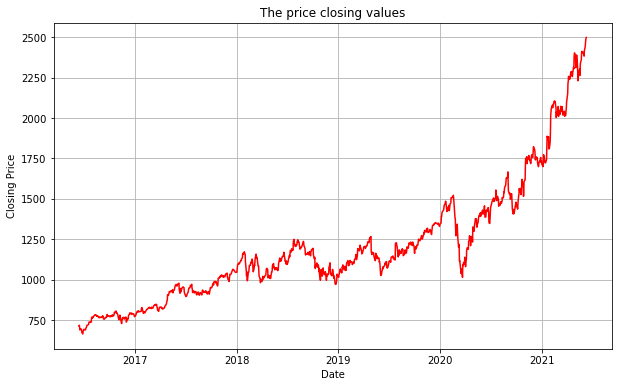

In [11]:
import matplotlib.pyplot as plt

# Extract closing prices
close = df.iloc[:, 2:3].values  # Assuming the closing price column is at index 2

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, closing_prices, color='red')
plt.title('The price closing values')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Ensure 'df' has at least 3 columns
if df.shape[1] >= 3:
    # Extract closing prices from the DataFrame
    close = df.iloc[:, 2].values  # Assuming closing prices are in the third column

    # Reshape the closing prices to fit the scaler
    closereshaped = close.reshape(-1, 1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the data with the scaler
    data_normalized = scaler.fit_transform(closereshaped)

    # Optionally, convert the normalized data back to a DataFrame for further use
    df['normalized_close'] = data_normalized

    # Inspect the normalized data
    df[['normalized_close']].head()
else:
    "DataFrame does not have enough columns to normalize closing prices."


In [13]:
from sklearn.model_selection import train_test_split

# Ensure that data_normalized exists and is a 2D array
if 'data_normalized' in locals():
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(data_normalized, test_size=0.2, shuffle=False)

    # Inspect the shapes of the resulting sets
    "Training data shape: {train_data.shape}"
    "Testing data shape: {test_data.shape}"
else:
    "data_normalized is not defined. Ensure that the normalization step is completed successfully."


In [14]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import os

# Assume df is already defined and contains the stock data with the closing prices

# Normalize Closing Prices
scaler = MinMaxScaler(feature_range=(0, 1))
close = df.iloc[:, 2:3].values.reshape(-1, 1)  # Reshape to fit the scaler
data_normalized = scaler.fit_transform(close)

# Splitting Normalized Data
train_data, test_data = train_test_split(data_normalized, test_size=0.2, shuffle=False)

# Define the time step
time_step = 100

# Implement the prepare_data function
def prepare_data(data, time_step):
    generator = TimeseriesGenerator(data, data, length=time_step, batch_size=1)
    return generator

# Prepare generators for training and testing data
train_generator = prepare_data(train_data, time_step)
test_generator = prepare_data(test_data, time_step)

# Build the LSTM model
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_generator, epochs=3)

# Generate predictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

# Evaluate model performance metrics
def calculate_metrics(true_data, predictions):
    mse = mean_squared_error(true_data, predictions)
    mae = mean_absolute_error(true_data, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_data, predictions)
    return mse, mae, rmse, r2

# Prepare true data for evaluation
train_true = train_data[time_step:]
test_true = test_data[time_step:]

# Calculate metrics
train_mse, train_mae, train_rmse, train_r2 = calculate_metrics(train_true, train_predictions)
test_mse, test_mae, test_rmse, test_r2 = calculate_metrics(test_true, test_predictions)

# Store metrics in a DataFrame
results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'R2'],
    'Training': [train_mse, train_mae, train_rmse, train_r2],
    'Testing': [test_mse, test_mae, test_rmse, test_r2]
})

# Export the results to a CSV file
results_file = 'model_metrics.csv'
results.to_csv(results_file, index=False)

# Debugging: Check if the file is created and print its contents
if os.path.exists(results_file):
    "The file '{results_file}' has been created successfully."
    results
else:
    "Failed to create the file '{results_file}'."


ModuleNotFoundError: No module named 'keras'